In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
from sklearn.cluster import OPTICS
import optuna
import logging
import sys
from sklearn.metrics import silhouette_score
import plotly.express as px
import pywt
from sklearn.preprocessing import StandardScaler
import scipy.stats.stats as st
import time
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

plt.rcParams['figure.figsize'] = [15, 5]
plt.style.use('seaborn-deep');

In [2]:
asks = pd.read_csv('Asks.csv', header=None)
bids = pd.read_csv('Bids.csv', header=None)

col_names = ['time']
lv = 1
for i in range(1, asks.shape[1], 3):
    col_names.append('order'+str(lv))
    col_names.append('price'+str(lv))
    col_names.append('volume'+str(lv))
    lv += 1

asks.columns = col_names
bids.columns = col_names
asks.head(3)

time       order1        price1   volume1       order2  \
0  1.604030e+09  53001558049  13437.000000 -1.000000  53006686518   
1  1.604030e+09  53006737904  13435.043112 -0.041757  53006686518   
2  1.604030e+09  53006737906  13433.766176 -0.010000  53006737904   

         price2   volume2       order3   price3   volume3  ...  volume97  \
0  13437.000000 -0.400040  53006729547  13437.0 -0.022328  ... -4.199900   
1  13436.000000 -0.384894  53006730643  13436.0 -0.106472  ... -0.312879   
2  13433.874034 -0.041757  53006686518  13434.0 -0.384911  ... -1.114421   

       order98  price98  volume98      order99       price99  volume99  \
0  53006740985  13468.0 -1.487708  53001297177  13469.000000   -2.6497   
1  53006727209  13470.0 -0.148757  52955915169  13470.430324   -0.5689   
2  52999487837  13465.0 -2.320000  52999487845  13465.000000   -2.3200   

      order100      price100  volume100  
0  53006634551  13469.000000  -0.312879  
1  52986159744  13470.430324  -1.729846  
2  53005332351  13465.000000  -3.000000  

[3 rows x 301 columns]

In [3]:
for l in range(1, 101):
    asks['volume'+str(l)] = asks['volume'+str(l)] * (-1)

In [4]:
""""n_train = round(asks.shape[0]/24) * 3#2
asks_train = asks.iloc[:n_train, :]
bids_train = bids.iloc[:n_train, :]
n_train

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-4-d158aa1a00ba>, line 4)

## Features
### Discrete Wavelet Transform
Using Symlets (paper on HMM) with smooth padding

More at: http://www.ece.northwestern.edu/local-apps/matlabhelp/toolbox/wavelet/ch06_a20.html, 
https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes

In [ ]:
""""def DWT(df, str_):
    (ca, cd) = pywt.dwt(df[str_+'_price'], 'sym2', 'smooth')
    sigma_wv = np.median(np.abs(cd)) / 0.6745
    thresh_wv = sigma_wv * np.sqrt(2*np.log(len(df[str_+'_price'])))
    cd[np.abs(cd) < thresh_wv] = 0
    ts_recons = pywt.idwt(ca, cd, 'sym2', 'smooth')
    return ts_recons

### Microstructural variables

In [4]:
#Order imbalance
def micro_var(lv, rolling_window, df_bid, df_ask):
    OI = (df_bid['volume'+str(lv)] - df_ask['volume'+str(lv)]) / (df_bid['volume'+str(lv)] + df_ask['volume'+str(lv)]) 
    QS = (df_ask['price'+str(lv)] - df_bid['price'+str(lv)]) * 100 / ((df_ask['price'+str(lv)] + df_bid['price'+str(lv)])/2) 
    ret_sqrt_ask = (np.log(df_ask['price'+str(lv)]) - np.log(df_ask['price'+str(lv)].shift(1)))**2
    ret_sqrt_ask = ret_sqrt_ask.rolling(rolling_window).sum()
    ret_sqrt_bid = (np.log(df_bid['price'+str(lv)]) - np.log(df_bid['price'+str(lv)].shift(1)))**2
    ret_sqrt_bid = ret_sqrt_bid.rolling(rolling_window).sum()
    return  pd.Series(OI), pd.Series(QS), pd.Series(ret_sqrt_ask), pd.Series(ret_sqrt_bid)

In [11]:
def make_df(lv, window, df_bid, df_ask):
    #ask_dwt = pd.Series(DWT(df_ask, lv))
    #bid_dwt = pd.Series(DWT(df_bid, lv))
    #ask_dwt_grad = pd.Series(np.gradient(ask_dwt, 1))
    #bid_dwt_grad = pd.Series(np.gradient(bid_dwt, 1))
    ask_prices = df_ask['price' + str(lv)]
    bid_prices = df_bid['price' + str(lv)]
    ask_prices_grad = pd.Series(np.gradient(ask_prices, 1))
    bid_prices_grad = pd.Series(np.gradient(bid_prices, 1))
    imbalance, spread, ask_volatility, bid_volatility = micro_var(lv, window, df_bid, df_ask) #minute window

    df = pd.concat([ask_prices, ask_prices_grad, ask_volatility, bid_prices, bid_prices_grad, bid_volatility, imbalance, spread], axis = 1)
    names = ['ask_price', 'ask_price_grad', 'ask_volat', 'bid_price', 'bid_price_grad', 'bid_volat', 'imbalance', 'spread']
    df.columns = names
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    return df

In [66]:
window_size = 12
lv1_df_train = make_df(1, window_size, bids, asks)
lv2_df_train = make_df(2, window_size, bids, asks)
lv3_df_train = make_df(3, window_size, bids, asks)
lv4_df_train = make_df(4, window_size, bids, asks)
lv5_df_train = make_df(5, window_size, bids, asks)
lv6_df_train = make_df(6, window_size, bids, asks)
lv7_df_train = make_df(7, window_size, bids, asks)
lv8_df_train = make_df(8, window_size, bids, asks)
lv9_df_train = make_df(9, window_size, bids, asks)
lv10_df_train = make_df(10, window_size, bids, asks)

In [67]:
lv1_df_train = lv1_df_train.iloc[:6000, :]
#lv1_df_train = make_small_df(lv1_df_train)
lv1_df_train

ask_price  ask_price_grad     ask_volat     bid_price  bid_price_grad  \
0       13440.0             4.0  1.342804e-07  13439.719423        3.831104   
1       13448.0             4.0  4.671656e-07  13447.175040        4.091773   
2       13448.0             0.0  4.581312e-07  13447.902969        0.363964   
3       13448.0             1.5  4.581312e-07  13447.902969        1.169078   
4       13451.0             1.5  5.078854e-07  13450.241124        1.169078   
...         ...             ...           ...           ...             ...   
5995    13342.0             1.0  1.554382e-07  13341.000000        1.000000   
5996    13346.0             0.0  2.190055e-07  13345.000000        0.000000   
5997    13342.0            -1.0  3.088617e-07  13341.000000       -1.000000   
5998    13344.0             1.0  3.257126e-07  13343.000000        1.000000   
5999    13344.0             0.5  3.257126e-07  13343.000000        0.000000   

         bid_volat  imbalance    spread  
0     1.350915e-07  -0.409106  0.002088  
1     4.345228e-07  -0.428571  0.006135  
2     4.152889e-07   0.712644  0.000722  
3     4.152889e-07  -0.914120  0.000722  
4     4.455136e-07   0.714286  0.005642  
...            ...        ...       ...  
5995  2.070602e-07  -0.958882  0.007495  
5996  2.463820e-07   0.957532  0.007493  
5997  3.362516e-07  -0.395331  0.007495  
5998  3.496073e-07   0.550388  0.007494  
5999  3.496073e-07   0.107963  0.007494  

[6000 rows x 8 columns]

In [118]:
''''lv1_df_cv = make_df(1, window_size, bids_cv, asks_cv)
lv2_df_cv = make_df(2, window_size, bids_cv, asks_cv)
lv3_df_cv = make_df(3, window_size, bids_cv, asks_cv)
lv4_df_cv = make_df(4, window_size, bids_cv, asks_cv)
lv5_df_cv = make_df(5, window_size, bids_cv, asks_cv)
lv6_df_cv = make_df(6, window_size, bids_cv, asks_cv)
lv7_df_cv = make_df(7, window_size, bids_cv, asks_cv)
lv8_df_cv = make_df(8, window_size, bids_cv, asks_cv)
lv9_df_cv = make_df(9, window_size, bids_cv, asks_cv)
lv10_df_cv = make_df(10, window_size, bids_cv, asks_cv)

lv1_df_test = make_df(1, window_size, bids_test, asks_test)
lv2_df_test = make_df(2, window_size, bids_test, asks_test)
lv3_df_test = make_df(3, window_size, bids_test, asks_test)
lv4_df_test = make_df(4, window_size, bids_test, asks_test)
lv5_df_test = make_df(5, window_size, bids_test, asks_test)
lv6_df_test = make_df(6, window_size, bids_test, asks_test)
lv7_df_test = make_df(7, window_size, bids_test, asks_test)
lv8_df_test = make_df(8, window_size, bids_test, asks_test)
lv9_df_test = make_df(9, window_size, bids_test, asks_test)
lv10_df_test = make_df(10, window_size, bids_test, asks_test)''''

SyntaxError: EOL while scanning string literal (<ipython-input-118-0a409cd399e6>, line 21)

### Scaling

In [198]:
#let`s see if we have some outliers
def plot_outliers(df):
    fig, axs = plt.subplots(4, 3, sharex=True, figsize=(10,10))
    axs[0, 0].boxplot(df['ask_price'])
    axs[0, 0].set_title('ask_price')
    axs[0, 0].set(ylabel = 'dollars')
    axs[1, 0].boxplot(df['ask_price_grad'])
    axs[1, 0].set_title('ask_price_grad')
    axs[1, 0].set(ylabel = '%')
    axs[2, 0].boxplot(df['ask_dwt'])
    axs[2, 0].set_title('ask_dwt')
    axs[2, 0].set(ylabel = 'dollars')
    axs[3, 0].boxplot(df['ask_dwt_grad'])
    axs[3, 0].set_title('ask_dwt_grad')
    axs[3, 0].set(ylabel = '%')
    axs[0, 1].boxplot(df['ask_volat'])
    axs[0, 1].set_title('ask_volat')
    axs[0, 1].set(ylabel = '%')
    axs[1, 1].boxplot(df['bid_price'])
    axs[1, 1].set_title('bid_price')
    axs[1, 1].set(ylabel = 'dollars')
    axs[2, 1].boxplot(df['bid_price_grad'])
    axs[2, 1].set_title('bid_price_grad')
    axs[2, 1].set(ylabel = '%')
    axs[3, 1].boxplot(df['bid_dwt'])
    axs[3, 1].set_title('bid_dwt')
    axs[3, 1].set(ylabel = 'dollars')
    axs[0, 2].boxplot(df['bid_dwt_grad'])
    axs[0, 2].set_title('bid_dwt_grad')
    axs[0, 2].set(ylabel = '%')
    axs[1, 2].boxplot(df['bid_volat'])
    axs[1, 2].set_title('bid_volat')
    axs[1, 2].set(ylabel = '%')
    axs[2, 2].boxplot(df['imbalance'])
    axs[2, 2].set_title('imbalance')
    axs[2, 2].set(ylabel = '%')
    axs[3, 2].boxplot(df['spread'])
    axs[3, 2].set_title('spread')
    axs[3, 2].set(ylabel = '%')
    fig.tight_layout()

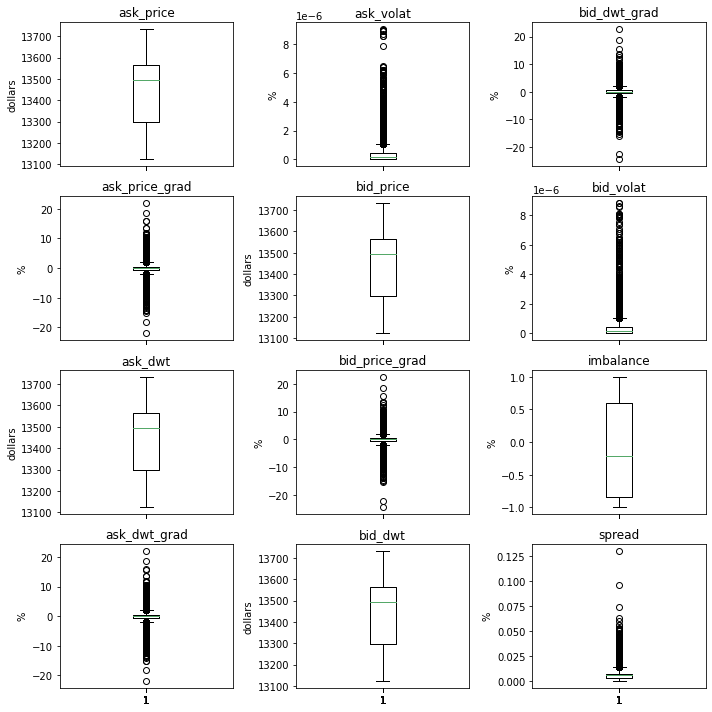

In [199]:
plot_outliers(lv1_df_train)

We can see there are outliers

In [200]:
def plot_distribution(df):
    fig, axs = plt.subplots(4, 3, figsize=(10,10))
    axs[0, 0].hist(df['ask_price'], 50)
    axs[0, 0].set_title('ask_price')
    axs[0, 0].set(xlabel = 'dollars', ylabel = 'count')
    axs[1, 0].hist(df['ask_price_grad'], 50)
    axs[1, 0].set_title('ask_price_grad')
    axs[1, 0].set(xlabel = '%', ylabel = 'count')
    axs[2, 0].hist(df['ask_dwt'], 50)
    axs[2, 0].set_title('ask_dwt')
    axs[2, 0].set(xlabel = 'dollars', ylabel = 'count')
    axs[3, 0].hist(df['ask_dwt_grad'], 50)
    axs[3, 0].set_title('ask_dwt_grad')
    axs[3, 0].set(xlabel = '%', ylabel = 'count')
    axs[0, 1].hist(df['ask_volat'], 50)
    axs[0, 1].set_title('ask_volat')
    axs[0, 1].set(xlabel = '%', ylabel = 'count')
    axs[1, 1].hist(df['bid_price'], 50)
    axs[1, 1].set_title('bid_price')
    axs[1, 1].set(xlabel = 'dollars', ylabel = 'count')
    axs[2, 1].hist(df['bid_price_grad'], 50)
    axs[2, 1].set_title('bid_price_grad')
    axs[2, 1].set(xlabel = '%', ylabel = 'count')
    axs[3, 1].hist(df['bid_dwt'], 50)
    axs[3, 1].set_title('bid_dwt')
    axs[3, 1].set(xlabel = 'dollars', ylabel = 'count')
    axs[0, 2].hist(df['bid_dwt_grad'], 50)
    axs[0, 2].set_title('bid_dwt_grad')
    axs[0, 2].set(xlabel = '%', ylabel = 'count')
    axs[1, 2].hist(df['bid_volat'], 50)
    axs[1, 2].set_title('bid_volat')
    axs[1, 2].set(xlabel = '%', ylabel = 'count')
    axs[2, 2].hist(df['imbalance'], 50)
    axs[2, 2].set_title('imbalance')
    axs[2, 2].set(xlabel = '%', ylabel = 'count')
    axs[3, 2].hist(df['spread'], 50)
    axs[3, 2].set_title('spread')
    axs[3, 2].set(xlabel = '%', ylabel = 'count')
    fig.tight_layout()

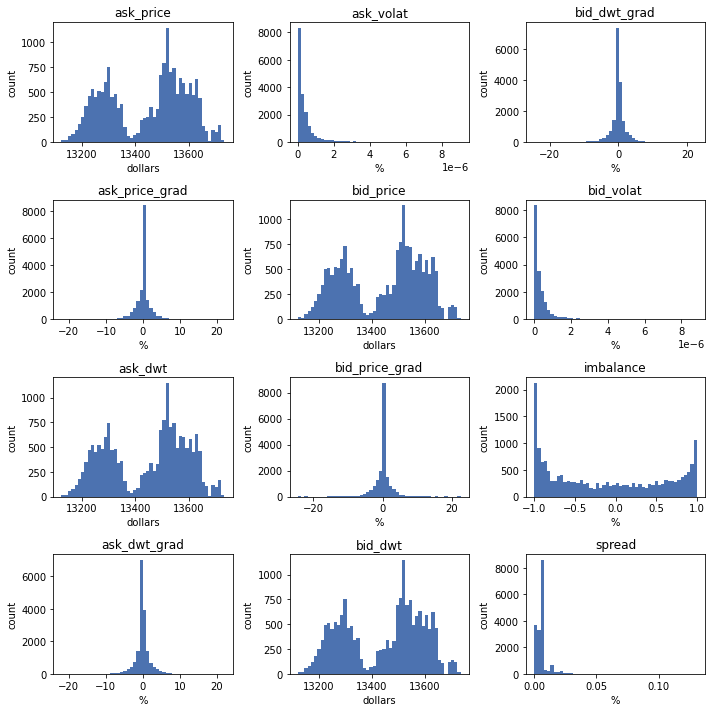

In [201]:
plot_distribution(lv1_df_train)

In [14]:
def scale(df):
    scaler = StandardScaler()
    scaler.fit(df)
    train_scaled = scaler.transform(df)
    train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
    return train_scaled

In [229]:
#plot_distribution(lv1_train_scaled)

In [125]:
#plot_outliers(lv1_train_scaled)

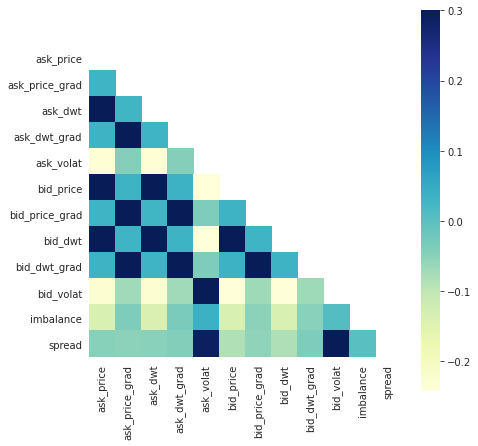

In [126]:
corr = lv1_train_scaled.corr() #low correlation among features
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap="YlGnBu")

In [123]:
""""def objective(trial):
    n_components = trial.suggest_int("n_components", 12, 24)
    #kernel = trial.suggest_categorical("kernel", ["cosine", "rbf", 'poly', 'sigmoid']) #poly degree 3 by default, intercept 1
    min_samples = trial.suggest_int("min_samples", 5, 30, 1)#? increase
    xi = trial.suggest_uniform('xi', 0, 0.4)#? reduce
    gamma = trial.suggest_uniform('gamma', 1/2**15, 4.0)
    #metric = trial.suggest_categorical('metric', ['cosine', 'euclidean']) 
    
    pipe = Pipeline([('scaler', KernelPCA(n_components = n_components, kernel='rbf', gamma=gamma, fit_inverse_transform=False)), ('OPTICS', OPTICS(min_samples = min_samples, xi=xi, metric = 'euclidean', metric_params = dict(), cluster_method = 'xi'))])

    for step in range(50):
        pipe.fit(lv1_train_scaled)
        try:
            # Report intermediate objective value.
            intermediate_value = silhouette_score(lv1_train_scaled, pipe[1].labels_, metric = pipe.get_params()['OPTICS__metric'])
            trial.report(intermediate_value, step)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.TrialPruned()
            return silhouette_score(lv1_train_scaled, pipe[1].labels_, metric = pipe.get_params()['OPTICS__metric'])

        except ValueError: #None if only one class. Then silhouette_score cannot be applied
            pass""""


SyntaxError: EOL while scanning string literal (<ipython-input-123-1a4baa658d96>, line 24)

I considered Bayesian Optimization, Genetic algorithms (too computationaly expensive, https://en.wikipedia.org/wiki/Genetic_algorithm) and Parzen Trees (https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html)

Distances: https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa

https://stats.stackexchange.com/questions/6896/best-distance-measure-to-use

min_samples https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan

gamma https://www.researchgate.net/post/Does-anyone-know-what-is-the-Gamma-parameter-about-RBF-kernel-function

https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters

https://stats.stackexchange.com/questions/335566/why-a-large-gamma-in-the-rbf-kernel-of-svm-leads-to-a-wiggly-decision-boundary-a

xi https://en.wikipedia.org/wiki/OPTICS_algorithm

In [33]:
def objective(trial):
    n_components = trial.suggest_int("n_components", 12, 18)
    #kernel = trial.suggest_categorical("kernel", ["cosine", "rbf", 'poly', 'sigmoid']) #poly degree 3 by default, intercept 1
    min_samples = trial.suggest_int("min_samples", 5, 15, 1)#? increase
    xi = trial.suggest_uniform('xi', 0, 0.15)#? reduce
    gamma = trial.suggest_uniform('gamma', 1/2**8, 4)
    #metric = trial.suggest_categorical('metric', ['cosine', 'euclidean']) 
    
    pipe = Pipeline([('scaler', KernelPCA(n_components = n_components, kernel='rbf', gamma=gamma, fit_inverse_transform=False)), ('OPTICS', OPTICS(min_samples = min_samples, xi=xi, metric = 'euclidean', metric_params = dict(), cluster_method = 'xi'))])

    pipe.fit(lv1_df_train)
    try:
        # Report intermediate objective value.
        intermediate_value = silhouette_score(lv1_df_train, pipe[1].labels_, metric = 'euclidean')
        #trial.report(intermediate_value)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()
        return silhouette_score(lv1_df_train, pipe[1].labels_, metric = 'euclidean')

    except ValueError: #None if only one class. Then silhouette_score cannot be applied
        pass



In [68]:
def objective(trial, start, end):
    n_components = trial.suggest_int("n_components", 12, 16, 1)
    #kernel = trial.suggest_categorical("kernel", ["cosine", "rbf", 'poly', 'sigmoid']) #poly degree 3 by default, intercept 1
    min_samples = trial.suggest_int("min_samples", 10, 22, 2)#? increase
    xi = trial.suggest_float('xi', 0.1, 0.4, step=0.05)#? reduce
    gamma = trial.suggest_float('gamma', 0, 2, step=0.3)
    #metric = trial.suggest_categorical('metric', ['cosine', 'euclidean']) 
    
    pipe = Pipeline([('scaler', KernelPCA(n_components = n_components, kernel='rbf', gamma=gamma, fit_inverse_transform=False)), ('OPTICS', OPTICS(min_samples = min_samples, xi=xi, metric = 'euclidean', metric_params = dict(), cluster_method = 'xi'))])
    data_small = make_small_df(lv1_df_train.iloc[start:end, :].copy())
    pipe.fit(data_small)
    try:
        # Report intermediate objective value.
        intermediate_value = silhouette_score(data_small, pipe[1].labels_, metric = 'euclidean')
        #trial.report(intermediate_value)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()
        return silhouette_score(data_small, pipe[1].labels_, metric = 'euclidean')

    except ValueError: #None if only one class. Then silhouette_score cannot be applied
        intermediate_value = 0
        if trial.should_prune():
            raise optuna.TrialPruned()
        return 0



In [117]:
""""import random
random.seed(1)
start = 0
end = 730

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.CmaEsSampler(), pruner = optuna.pruners.HyperbandPruner())
study.optimize(lambda trial: objective(trial, start, end), n_trials=100)


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-117-6c394c9ed9f0>, line 8)

In [26]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))
end = 731
sliding_window = 12 # 12 in a minute
h = 0
for i in range(300):
    if lv1_df_train.shape[0] - end >= sliding_window:

        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.CmaEsSampler(), pruner = optuna.pruners.HyperbandPruner())
        study.optimize(lambda trial: objective(trial, h, end), n_trials=10)
        if h == 0:
            summary_df = pd.DataFrame(study.best_params, index=[0]).round(3)
            summary_df['score'] = study.best_value
            summary_df['count'] = 1
        else:   
            s = study.best_params.copy()
            s['score'] = study.best_value
            temp_df = pd.DataFrame(s, index=[0]).round(3)
            df_compare = summary_df[(summary_df['n_components']==temp_df['n_components'][0])&(summary_df['min_samples']==temp_df['min_samples'][0])&(summary_df['xi']==temp_df['xi'][0])&(summary_df['gamma']==temp_df['gamma'][0])]
            if df_compare.shape[0] > 0:
                summary_df[(summary_df['n_components']==temp_df['n_components'][0])&(summary_df['min_samples']==temp_df['min_samples'][0])&(summary_df['xi']==temp_df['xi'][0])&(summary_df['gamma']==temp_df['gamma'][0])].iloc[0, -1]+= 1
            else:
                temp_df['count'] = 1
                summary_df = pd.concat([summary_df,temp_df], axis = 0, ignore_index=True)

        end += sliding_window
        h += sliding_window
    else:

        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.CmaEsSampler(), pruner = optuna.pruners.HyperbandPruner())
        study.optimize(lambda trial: objective(trial, h, end), n_trials=10)
        s = study.best_params.copy()
        s['score'] = study.best_value
        temp_df = pd.DataFrame(s, index=[0]).round(3)
        df_compare = summary_df[(summary_df['n_components']==temp_df['n_components'][0])&(summary_df['min_samples']==temp_df['min_samples'][0])&(summary_df['xi']==temp_df['xi'][0])&(summary_df['gamma']==temp_df['gamma'][0])]
        if df_compare.shape[0] > 0:
            summary_df[(summary_df['n_components']==temp_df['n_components'][0])&(summary_df['min_samples']==temp_df['min_samples'][0])&(summary_df['xi']==temp_df['xi'][0])&(summary_df['gamma']==temp_df['gamma'][0])].iloc[0, -1]+= 1
        else:
            temp_df['count'] = 1
            summary_df = pd.concat([summary_df,temp_df], axis = 0, ignore_index=True)
        break

print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))

2021-02-23 08:59:23
[W 2021-02-23 12:00:19,265] The parameter 'n_components' in trial#9 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
The parameter 'n_components' in trial#9 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2021-02-23 12:00:19,265] The parameter 'min_samples' in trial#9 is sampled independently by using `RandomSampler` instead of 

In [39]:
summary_df.sort_values('score', ascending=False).iloc[:11,:].mean()

n_components    14.272727
min_samples     14.363636
xi               0.336364
gamma            0.490909
score            0.620909
count            1.000000
dtype: float64

In [76]:
summary_df.median()

n_components    14.000
min_samples     16.000
xi               0.300
gamma            1.000
score            0.474
count            1.000
dtype: float64

In [107]:
a = pd.DataFrame(study.best_params, index=[0])
b = pd.DataFrame(study.best_params, index=[0])
pd.concat([a,b], axis = 0, ignore_index=True)

In [35]:


plot_param_importances(study)

In [36]:
plot_slice(study)

In [141]:
#plot_optimization_history(study)


In [38]:
plot_parallel_coordinate(study)

In [39]:
params = study.best_params
params

{'n_components': 13,
 'min_samples': 14,
 'xi': 0.1380407719456885,
 'gamma': 3.7855362134811275}

In [43]:
pipe_chosen = Pipeline([('scaler', KernelPCA(n_components = 15, kernel='rbf', gamma=0.5244447882848909)), ('OPTICS', OPTICS(min_samples = 21, xi=0.4713437720699284, metric = 'euclidean', cluster_method = 'xi'))])
pipe_chosen.fit(lv1_train_scaled)
#silhouette_score(lv1_train_scaled, pipe_chosen[1].labels_, metric = 'euclidean')

Pipeline(steps=[('scaler',
                 KernelPCA(gamma=0.5244447882848909, kernel='rbf',
                           n_components=15)),
                ('OPTICS',
                 OPTICS(metric='euclidean', min_samples=21,
                        xi=0.4713437720699284))])

In [56]:
#lv1_1_df['label'] = pipe_chosen[1].labels_
#print('Labels: {}'.format(str(lv1_train_scaled['label'].unique())))
X = lv1_df_train#.drop(columns=['class', 'score'])

In [57]:
from sklearn.decomposition import PCA
kpca_3d = KernelPCA(n_components = 3, kernel='linear', gamma=0) 
kpca_3d.fit_transform(X)
kpca_3d_df = pd.DataFrame(kpca_3d.fit_transform(X))
kpca_3d_df.columns = ['PC1', 'PC2', 'PC3']
kpca_3d_df['label'] = lv1_df_train['class']
fig_3D = px.scatter_3d(kpca_3d_df, x='PC1', y='PC2', z='PC3',
              color='label')
fig_3D.show()

In [58]:
kpca_2d = KernelPCA(n_components = 2, kernel='linear')
kpca_2d.fit_transform(X)
kpca_2d_df = pd.DataFrame(kpca_2d.fit_transform(X))
kpca_2d_df.columns = ['PC1', 'PC2']
kpca_2d_df['label'] = lv1_df_train['class']
fig_2D = px.scatter(kpca_2d_df, x='PC1', y='PC2', color='label')
fig_2D.show()

In [15]:
def DWT(df, str_):
    (ca, cd) = pywt.dwt(df[str_+'_price'], 'sym2', 'smooth')
    sigma_wv = np.median(np.abs(cd)) / 0.6745
    thresh_wv = sigma_wv * np.sqrt(2*np.log(len(df[str_+'_price'])))
    cd[np.abs(cd) < thresh_wv] = 0
    ts_recons = pywt.idwt(ca, cd, 'sym2', 'smooth')
    return ts_recons

def make_small_df(df):
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    df['ask_dwt'] = pd.Series(DWT(df, 'ask'), dtype='float64')
    df['bid_dwt'] = pd.Series(DWT(df, 'bid'), dtype='float64')
    df['ask_dwt_grad'] = pd.Series(np.gradient(df['ask_dwt'], 1))
    df['bid_dwt_grad'] = pd.Series(np.gradient(df['bid_dwt'], 1))
    df = scale(df)
    return df

In [77]:
#pipe_chosen = Pipeline([('scaler', KernelPCA(n_components = params['n_components'], kernel='rbf', gamma= params['gamma'])), ('OPTICS', OPTICS(min_samples = params['min_samples'], xi=params['xi'], metric = 'euclidean', cluster_method = 'xi'))])
pipe_chosen = Pipeline([('scaler', KernelPCA(n_components = 14, kernel='rbf', gamma=1)), ('OPTICS', OPTICS(min_samples = 16, xi=.3, metric = 'euclidean', cluster_method = 'xi'))])

In [78]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))
label = np.full((lv1_df_train.shape[0]), 0, dtype ='float64')
scores = list()
end = 731
sliding_window = 12 # 12 in a minute
h = 0
for i in range(17000):
    if lv1_df_train.shape[0] - end >= sliding_window:
        dataset = lv1_df_train.iloc[h:end, :].copy()
        dataset = make_small_df(dataset)
        pipe_chosen.fit(dataset)
        try:
            SC = silhouette_score(dataset, pipe_chosen[1].labels_, metric = 'euclidean')
        except ValueError:
            SC = 0
        scores.append(SC)
        if h == 0:
            label[:end] = pipe_chosen[1].labels_
        else:
            label[end-sliding_window:end] = pipe_chosen[1].labels_[-sliding_window:]

        end += sliding_window
        h += sliding_window
    else:
        dataset = lv1_df_train.iloc[h:, :].copy()
        dataset = make_small_df(dataset)
        pipe_chosen.fit(dataset)
        try:
            SC = silhouette_score(dataset, pipe_chosen[1].labels_, metric = 'euclidean')
        except ValueError:
            SC = 0
        scores.append(SC)
        label[-(lv1_df_train.shape[0] - end):] = pipe_chosen[1].labels_[-(lv1_df_train.shape[0] - end):]
        break

print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))

2021-02-23 10:04:15
2021-02-23 10:07:49


In [79]:
print('Score is {}'.format(np.nanmean(np.array(scores, dtype=np.float64))))
lv1_df_train['class'] = label
lv1_df_train[lv1_df_train['class']==1].head()

Score is 0.3757954623270503


ask_price  ask_price_grad     ask_volat     bid_price  bid_price_grad  \
3014    13329.0             5.0  2.216030e-06  13328.000000        4.883432   
5423    13261.0             0.0  7.940934e-22  13260.964674        0.000000   
5424    13261.0             0.0  7.940934e-22  13260.964674        0.000000   
5425    13261.0             0.0  7.940934e-22  13260.964674        0.000000   
5426    13261.0             0.0  7.940934e-22  13260.964674        0.000000   

         bid_volat  imbalance    spread  class  
3014  2.338147e-06  -0.881002  0.007503    1.0  
5423 -7.146840e-22  -0.735750  0.000266    1.0  
5424 -7.146840e-22  -0.735750  0.000266    1.0  
5425 -7.146840e-22  -0.735750  0.000266    1.0  
5426 -7.146840e-22  -0.950753  0.000266    1.0

In [144]:
lv1_df_train['class'].unique()

array([ 0., -1.,  1.])

In [101]:
fig = plt.subplot()
fig.plot(lv1_df_train.index, lv1_df_train['ask_price'], 'blue')
df_plot = lv1_df_train[lv1_df_train['class']==0]
ind_st = np.array(df_plot.index)[0]
ind_next = np.array(df_plot.index)[1]
for p in np.array(df_plot.index):
        if p-1 == ind_st or p == np.array(df_plot.index)[0]:
            if p + 1 = ind_next:
                
#fig.plot(lv1_df_train[lv1_df_train['class']==0].index,lv1_df_train[lv1_df_train['class']==0]['ask_price'], 'red')
#fig.fill_betweenx([lv1_df_train['ask_price'].min(), lv1_df_train['ask_price'].max()], 0, 90, color = 'yellow')

SyntaxError: invalid syntax (<ipython-input-101-b9e0b85aee16>, line 8)

In [142]:
vol2 = np.full(lv1_df_train.shape[0], None)
ind = np.array(lv1_df_train[lv1_df_train['class']==-1].index)
for p in ind:
    vol2[p] = lv1_df_train['ask_price'][p]
vol2 = pd.DataFrame(vol2, columns=['vol'])


In [118]:
#

In [143]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=vol.index, y=vol.iloc[:, 0]))
fig.add_trace(go.Scatter(x=vol1.index, y=vol1.iloc[:, 0]))
fig.add_trace(go.Scatter(x=vol2.index, y=vol2.iloc[:, 0]))
fig.update_xaxes(rangeslider_visible=True)
fig.show()